In [1]:

import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os

import matplotlib  as mpl
import matplotlib.pyplot as plt

%matplotlib inline
# Optionally, tweak styles.
mpl.rc('figure',  figsize=(22*1.5, 12*1.5))
mpl.rc('image', cmap='gray')

In [2]:
datapath = '../fingercam_undistorted/init/*.jpg'

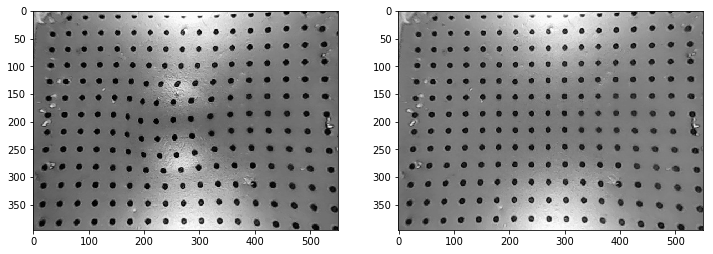

In [3]:
id_example = 0
rawframes = pims.ImageSequence(datapath)
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(rawframes[0])
plt.subplot(2,2,2)
plt.imshow(rawframes[1])

In [4]:
def crop(img): # no need here for the whole dataset has been crop before
    """
    Crop the image to select the region of interest
    """
    x_min = 45
    x_max = -35
    y_min = 100
    y_max = -300
    return img[y_min:y_max,x_min:x_max]

In [5]:
from scipy import ndimage
from skimage import morphology, util, filters

In [6]:

def preprocess(img):
    """
    Apply image processing functions to return a binary image
    """
    # Crop the pictures as for raw images.
#     img = crop(img)
    # Apply thresholds
    img = filters.threshold_local(img, 3)
    threshold = 0.15
    idx = img > img.max() * threshold
    idx2 = img < img.max() * threshold
    img[idx] = 0
    img[idx2] = 255
    # Dilatate to get a continous network
    # of liquid films
    
#     plt.figure()
#     plt.subplot(2,2,1)
#     plt.imshow(img)
    
#     img = ndimage.binary_erosion(img, ndimage.generate_binary_structure(2,1))
    
    struct = ndimage.generate_binary_structure(2, 5)
    img = ndimage.binary_dilation(img, structure=struct)
#     plt.subplot(2,2,2)
#     plt.imshow(img)
#     plt.title('dilation with 2 connect')
    img = ndimage.binary_erosion(img, ndimage.generate_binary_structure(2,9))
#     plt.subplot(2,2,3)
#     plt.imshow(img)
    img = ndimage.binary_dilation(img, structure=struct)
    plt.subplot(2,2,4)
    plt.imshow(img)
    
    return util.img_as_int(img)


frames = pims.ImageSequence(datapath, process_func=preprocess)

# frames = preprocess(rawframes[0])
# plt.figure()
# plt.subplot(2,1,1)
# plt.imshow(frames)
# plt.subplot(2,1,2)
# plt.imshow(frames[1])

In [7]:
# frames = preprocess(rawframes[1])
# plt.imshow(frames)

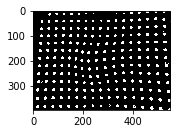

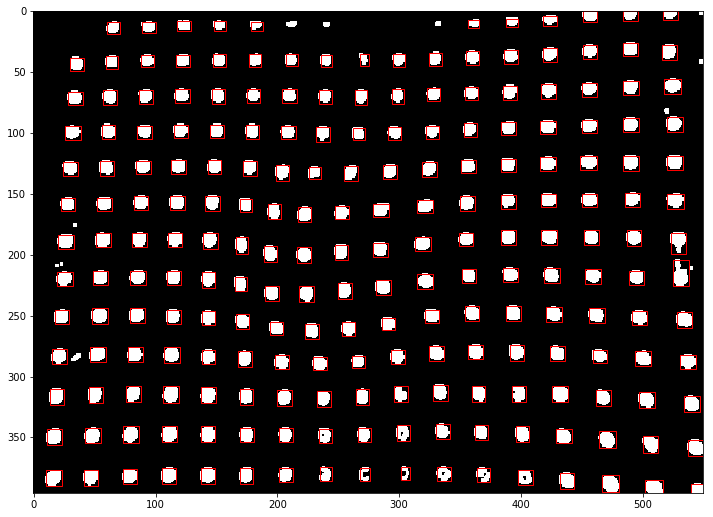

In [8]:
import skimage
import matplotlib.patches as mpatches

img_example = frames[id_example]

# Label elements on the picture
label_image = skimage.measure.label(img_example)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(img_example)

white = np.ones((img_example.shape[0], img_example.shape[1]))
img_example = white - img_example
for region in skimage.measure.regionprops(label_image, intensity_image=img_example):
    # Everywhere, skip small and large areas
#     print(region.area)
    if region.area < 45 or region.area > 800:
        continue
    # Only black areas
    if region.mean_intensity > 1:
        continue
    # On the top, skip small area with a second threshold
#     if region.centroid[0] < 260 and region.area < 80:
#         continue
    # Draw rectangle which survived to the criterions
    minr, minc, maxr, maxc = region.bbox
    
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)

    ax.add_patch(rect)

/home/adam/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


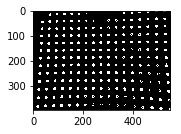

In [9]:
features = pd.DataFrame()
for num, img in enumerate(frames):
    plt.imshow(img)
    label_image = skimage.measure.label(img)
    
    white = np.ones((img.shape[0], img.shape[1]))
    img = white - img
    
    for region in skimage.measure.regionprops(label_image, intensity_image=img):
        # Everywhere, skip small and large areas
        if region.area < 40 or region.area > 800:
            continue
        # Only black areas
        if region.mean_intensity > 1:
            continue
        # On the top, skip small area with a second threshold
#         if region.centroid[0] < 260 and region.area < 80:
#             continue
        # Store features which survived to the criterions
        features = features.append([{'y': region.centroid[0],
                                     'x': region.centroid[1],
                                     'frame': num,
                                     },])
        
# print(features)

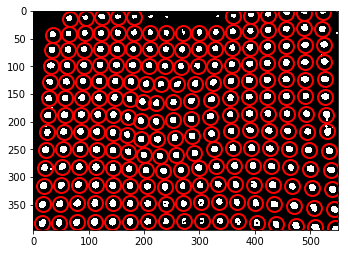

In [10]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))

tp.annotate(features[features.frame==0], frames[0])

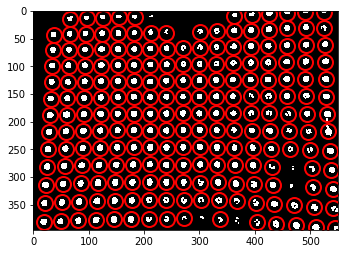

In [11]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))

tp.annotate(features[features.frame==1], frames[1])

Frame 1: 210 trajectories present


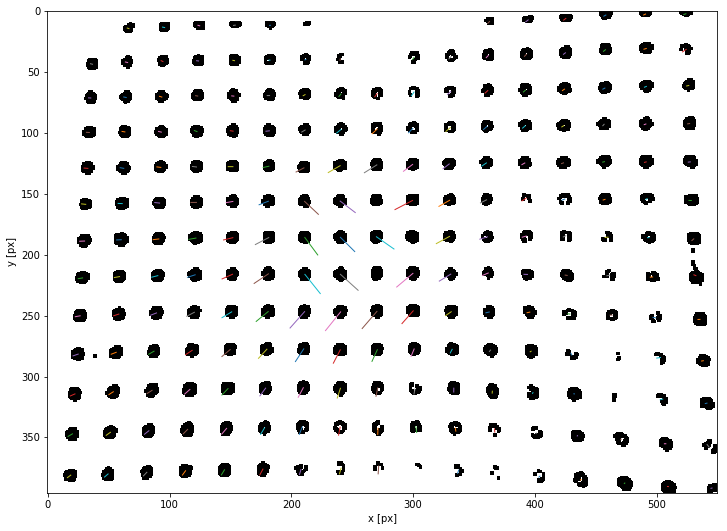

In [12]:
import trackpy.linking.legacy as tpl


search_range = 22
t = tpl.link_df(features, search_range, memory=1, diagnostics=True)

# print(t)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
plt.imshow(img)
tp.plot_traj(t)

In [85]:
# for i, item in enumerate(np.array(t[t.frame==1].particle)):
#     print(i, item)
t

,frame,x,y,particle,diag_search_range,diag_subnet,diag_subnet_iterations,diag_subnet_size
0,0,456.714286,3.989011,0.0,NaN,NaN,NaN,NaN
1,1,458.379747,3.063291,0.0,1,NaN,NaN,NaN
2,0,489.402439,3.036585,1.0,NaN,NaN,NaN,NaN
3,1,491.000000,2.283333,1.0,1,NaN,NaN,NaN
4,0,522.402778,2.597222,2.0,NaN,NaN,NaN,NaN
5,1,524.129630,2.055556,2.0,1,NaN,NaN,NaN
6,0,423.743590,7.205128,3.0,NaN,NaN,NaN,NaN
7,1,425.500000,5.837838,3.0,1,NaN,NaN,NaN
8,0,392.539683,8.698413,4.0,NaN,NaN,NaN,NaN
9,1,394.561404,7.087719,4.0,1,NaN,NaN,NaN


In [13]:
unstacked = t.set_index(['frame', 'particle']).unstack()

data = pd.DataFrame()
for item in set(t.particle):
    sub = t[t.particle==item]
    dvx = np.diff(sub.x)
    dvy = np.diff(sub.y)
    for x, y, dx, dy, frame in zip(sub.x[:-1], sub.y[:-1], dvx, dvy, sub.frame[:-1],):
        data = data.append([{'dx': dx,
                             'dy': dy,
                             'x': x,
                             'y': y,
                             'frame': frame,
                             'particle': item,
                            }])

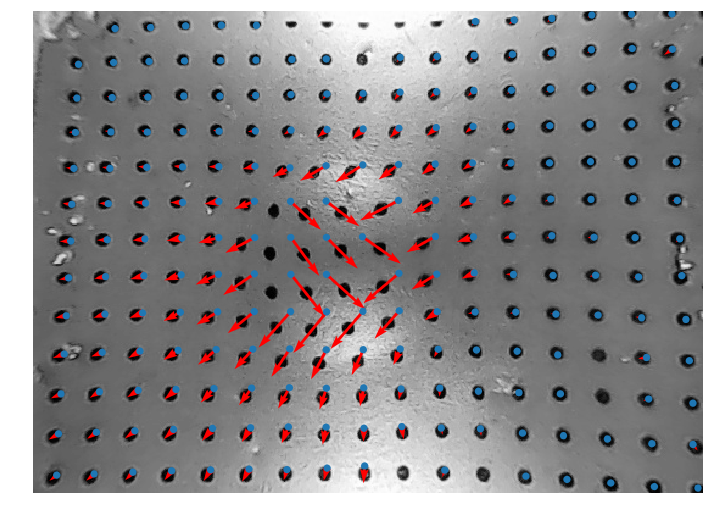

In [14]:
# print(data)

from matplotlib.pyplot import quiver



i = 0
d = data[data.frame==i]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))

ax.imshow(rawframes[0])
ax.quiver(d.x+d.dx, d.y + d.dy, -d.dx, +d.dy,  color='red', scale=250)

from matplotlib.patches import Circle


dots  = data[data.frame == 0]
# print(dots)
for (x, y) in zip(dots.x + dots.dx, dots.y + dots.dy):
#     print(x, y)
    Cir  = Circle((x, y), 3)
    ax.add_patch(Cir)

plt.axis('off')
plt.show()

In [15]:
x = features[features.frame==1]
# print(x)
X = x.values[:, 1:3]
# print(x)
y = features[features.frame==0]
Y = y.values[:, 1:3]
# print(Y[:50,:] - X[:50,/ :])


print(Y)

from scipy.io import savemat

savemat('two_data_sets.mat', mdict={'X': X, 'Y': Y})

[[456.71428571   3.98901099]
 [489.40243902   3.03658537]
 [522.40277778   2.59722222]
 [423.74358974   7.20512821]
 [392.53968254   8.6984127 ]
 [361.35185185   9.96296296]
 [123.3125      11.4875    ]
 [152.50746269  11.56716418]
 [ 65.24137931  13.77011494]
 [ 94.2195122   12.97560976]
 [182.20689655  11.56896552]
 [489.66101695  31.13559322]
 [456.41121495  32.86915888]
 [521.32231405  33.32231405]
 [423.56521739  35.30434783]
 [391.52336449  36.96261682]
 [360.13861386  38.06930693]
 [329.48913043  39.07608696]
 [151.99019608  40.2745098 ]
 [181.65168539  40.12359551]
 [211.20481928  39.89156627]
 [270.84782609  39.45652174]
 [299.61363636  39.69318182]
 [ 93.09782609  40.56521739]
 [122.21649485  40.59793814]
 [240.03846154  40.26923077]
 [ 63.70967742  41.64516129]
 [ 35.00970874  43.06796117]
 [524.73228346  61.34645669]
 [490.07258065  62.34677419]
 [455.89285714  63.94642857]
 [422.68965517  65.11206897]
 [390.6637931   66.26724138]
 [359.17346939  67.18367347]
 [328.30526316

[[ 6  0  7 11]
 [ 7  1  8  6]
 [ 8  2  7  1]
 [ 3  8  2  4]
 [ 4  9  3  5]
 [ 5 10  4  9]
 [11  6 12 17]
 [12  7 13 11]
 [13  8 14 12]
 [14 13  9  8]
 [ 9 15 10 14]
 [10 16  9  5]
 [17 11 18 12]
 [18 12 17 13]
 [13 18 12 14]
 [14 19 13 15]
 [15 20 14 16]
 [16 21 15 10]
 [17 18 11 12]
 [18 17 12 13]
 [18 19 13 12]
 [19 20 14 13]
 [20 19 21 15]
 [21 20 16 15]]
iteration 1, error 2.34856
iteration 2, error 0.65807
iteration 3, error 0.34027
iteration 4, error 0.22042
iteration 5, error 0.15782
iteration 6, error 0.12043
iteration 7, error 0.09593
iteration 8, error 0.07877
iteration 9, error 0.06660
iteration 10, error 0.05872
iteration 11, error 0.05547
iteration 12, error 0.05828
iteration 13, error 0.06984
iteration 14, error 0.08320
iteration 15, error 0.02939
iteration 16, error 0.00024
iteration 17, error 0.00000


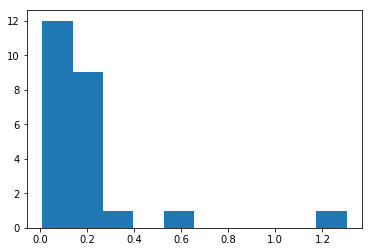

In [47]:
from functools import partial
from scipy.io import loadmat
from deformable_registration import *
from scipy.io import loadmat
from sklearn.neighbors import KDTree


def gaussian_2d(coeff, data):
    
    x = data[:, 0]
    y = data[:, 1]
    
    amplitude, xo, yo, sigma_x, sigma_y, theta, offset = np.split(coeff, 7)
    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    
    out = offset + amplitude*np.exp(-( a*(x - xo)**2 + 2*b*(x - xo)*(y - y0) + c*(y - yo)**2 ))
    
    return out

def visualize(iteration, error, X, Y, ax):
#     plt.cla()
#     print(Y[1, :])
#     ax.scatter(X[:,0] ,  X[:,1], color='red')
#     ax.scatter(Y[:,0] ,  Y[:,1], color='blue')
#     plt.draw()
    print("iteration %d, error %.5f" % (iteration, error))
#     plt.pause(0.0001)

# def main(X, Y):

# fig = plt.figure()
# fig.add_axes([0, 0, 1, 1])

fish = loadmat('fish.mat')
xx = fish['X']
yy = fish['Y']

# test synthetic data
xx = np.array([[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6.0, 0],
                   [1, 1], [2, 1], [3, 1], 
#                [4, 1],
               [5, 1], [6.0, 1],
                   [1, 2], [2, 2], [3, 2], [4, 2], [5, 2], [6.0, 2],
                   [1, 3], [2, 3], 
#                [3, 3],
               [4, 3], [5, 3], [6.0, 3]])
yy = np.array([[1, 0.9], [2, 0.8], [3, 0.6], [4, 0.5], [5, 0.3], [6, 0.1],
                   [1, 1.9], [2, 1.8], [3, 1.6], [4, 1.5], [5, 1.3], [6.0, 1.1],
                   [1, 2.8], [2, 2.6], [3, 2.5], [4, 2.4], [5, 2.3], [6.0, 2.1],
                   [1, 3.8], [2, 3.6],
                   [3, 3.55],
                   [4, 3.5], [5, 3.4], [6.0, 3.1]])

K = 4

kdx = KDTree(xx, leaf_size=30, metric='euclidean')
idx = kdx.query(yy, k=K, return_distance=False)

# print(idx)

dist = []
for i in range(0, len(idx)):
    dist.append(xx[idx[i]] - np.tile(yy[i], (4,1)))
    
dist = np.array(dist)
diff = np.multiply(dist, dist)

diff = np.sum(diff, axis=2)
# print(diff)
plt.hist(diff[:,0])


callback = partial(visualize, ax=fig.axes[0])

reg = deformable_registration(xx, yy, tolerance=0.0001)
TY, a = reg.register(callback=callback)
# print(a)



# if __name__ == '__main__':
#     main(X, Y)

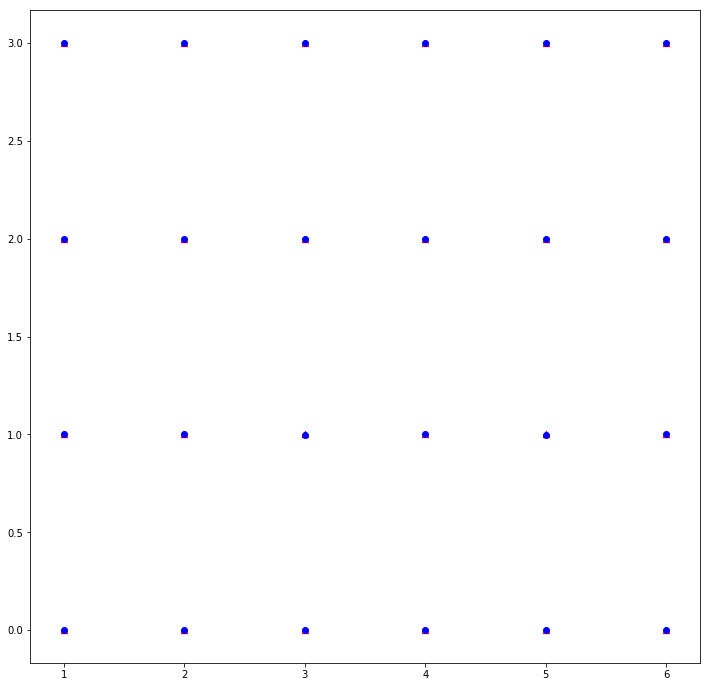

In [19]:
# plt.figure()
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))

# print(X)
# white = np.ones(Y.shape)


# plt.imshow(white)
plt.scatter(xx[:,0] ,xx[:,1]   , color='red', s = 40, marker='^')
# plt.savefig('Y.jpg', bbox_inches='tight')
plt.scatter(TY[:,0] , TY[:,1], color='blue')
# plt.show()

In [19]:

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

angle_between([0,1], [[1,0], [0.5,0.5]])

array([1.15026199, 1.15026199])

(210, 2)


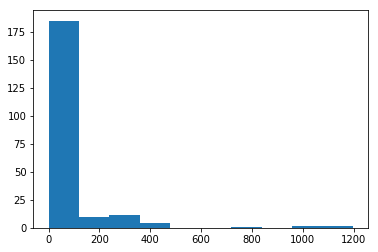

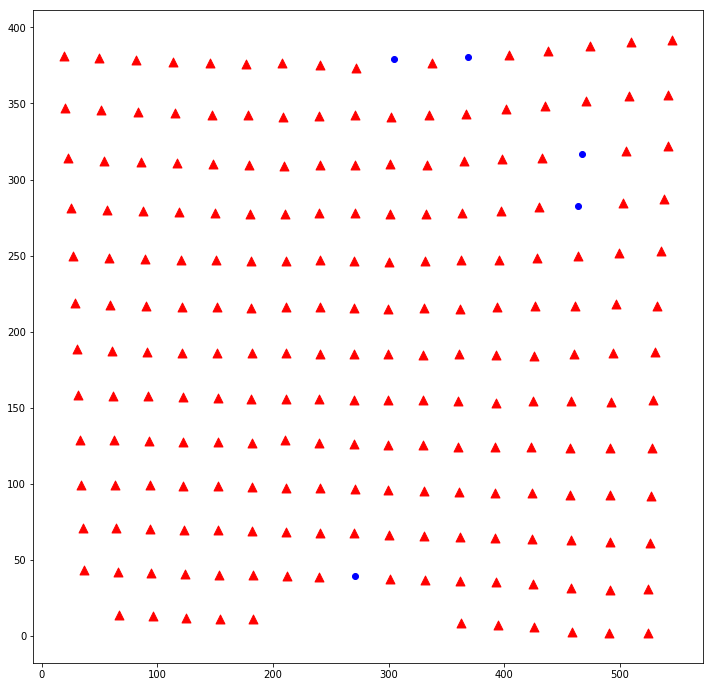

In [66]:
from sklearn.neighbors import KDTree
import numpy as np
import numpy.linalg as la

Y = features[features.frame == 0].values[:, 1:3]
X = features[features.frame == 1].values[:, 1:3]


K = 4
# print(Y)
kdX = KDTree(X, leaf_size=30, metric='euclidean')
idX = kdX.query(Y, k=K, return_distance=False)

# print(idX)
dist = []
for i in range(0, len(idX)):
    dist.append(X[idX[i]] - np.tile(Y[i], (4,1)))
    
dist = np.array(dist)
diff = np.multiply(dist, dist)

diff = np.sum(diff, axis=2)
# print(diff)
diff_nearest = diff[:, 0]
dn_id = (diff_nearest > 600)*1
dn_id_nonzero = np.where(dn_id)
plt.hist(diff[:,0])

fig = plt.figure(figsize=(12,12))
plt.scatter(X[:,0] ,X[:,1]   , color='red', s = 80, marker='^')
# plt.savefig('Y.jpg', bbox_inches='tight')
plt.scatter(Y[dn_id_nonzero,0] , Y[dn_id_nonzero,1], color='blue')


Y_wo_ol = np.delete(Y, dn_id_nonzero, 0)
print(Y_wo_ol.shape)

# outliers in Y has been removed

iteration 1, error 16756.58346
iteration 2, error 6323.17608
iteration 3, error 3438.56987
iteration 4, error 2177.68217
iteration 5, error 1498.77164
iteration 6, error 1088.16748
iteration 7, error 820.98493
iteration 8, error 637.95099
iteration 9, error 507.52655
iteration 10, error 411.59101
iteration 11, error 339.14201
iteration 12, error 283.20554
iteration 13, error 239.20086
iteration 14, error 204.02594
iteration 15, error 175.52306
iteration 16, error 152.15508
iteration 17, error 132.80314
iteration 18, error 116.63675
iteration 19, error 103.02844
iteration 20, error 91.49639
iteration 21, error 81.66539
iteration 22, error 73.23968
iteration 23, error 65.98394
iteration 24, error 59.70993
iteration 25, error 54.26697
iteration 26, error 49.53522
iteration 27, error 45.42095
iteration 28, error 41.85324
iteration 29, error 38.78168
iteration 30, error 36.17510
iteration 31, error 34.02126
iteration 32, error 32.32813
iteration 33, error 31.12766
iteration 34, error 30.484

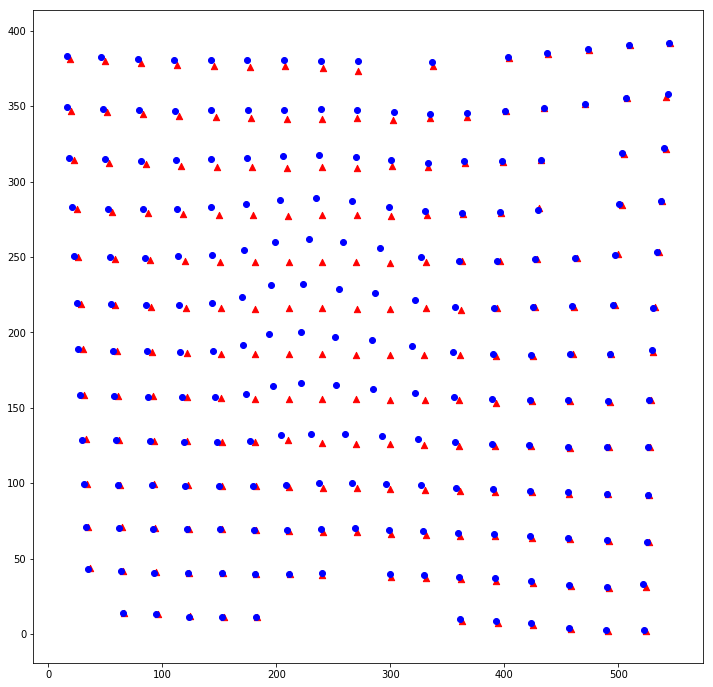

In [69]:
callback = partial(visualize, ax=fig.axes[0])

reg = deformable_registration(X, Y_wo_ol, tolerance=0.0001)
TY, a = reg.register(callback=callback)


fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))

# print(X)
# white = np.ones(Y.shape)


# plt.imshow(white)
plt.scatter(X[:,0] ,X[:,1]   , color='red', s = 40, marker='^')
# plt.savefig('Y.jpg', bbox_inches='tight')
plt.scatter(TY[:,0] , TY[:,1], color='blue')

(210, 4, 2)
(210, 4, 2)
[0.059320320532491366, 0.938215449987969, 2.575821957190472, 0.4476153826740597]
[0.22722592974649267, 28.67968467733377, 32.814140419865, 33.00299616024164]
[0.09660227132744581, 0.9872292534465315, 2.594405317608169, 0.48748414135399587]
[0.28108017260283197, 27.840610991943066, 33.11264702301158, 32.59058784571826]
[0.2167653570248122, 0.9605320498626703, 0.49247633289674403, 0.18008759617057185]
[0.42817381423779044, 30.319358179672502, 33.039237017919575, 43.18395721806392]
[0.03711645910603165, 0.8808800929592407, 2.5764037274760936, 0.5377784326121557]
[0.10867664015551977, 28.125041375762613, 33.22979249480952, 31.13539610825231]
[0.0037378932841670262, 2.4685852945760915, 0.8004686043909384, 0.5826206179160895]
[0.08089646983506733, 31.179974608556584, 28.341926760603183, 31.272796129326736]
[0.10276031031584747, 2.412457280151222, 0.7620501653983061, 1.6398301275280214]
[0.7500183039179156, 31.90993387868102, 27.802082946139535, 40.79695705852344]
[0.2

<IPython.core.display.Javascript object>


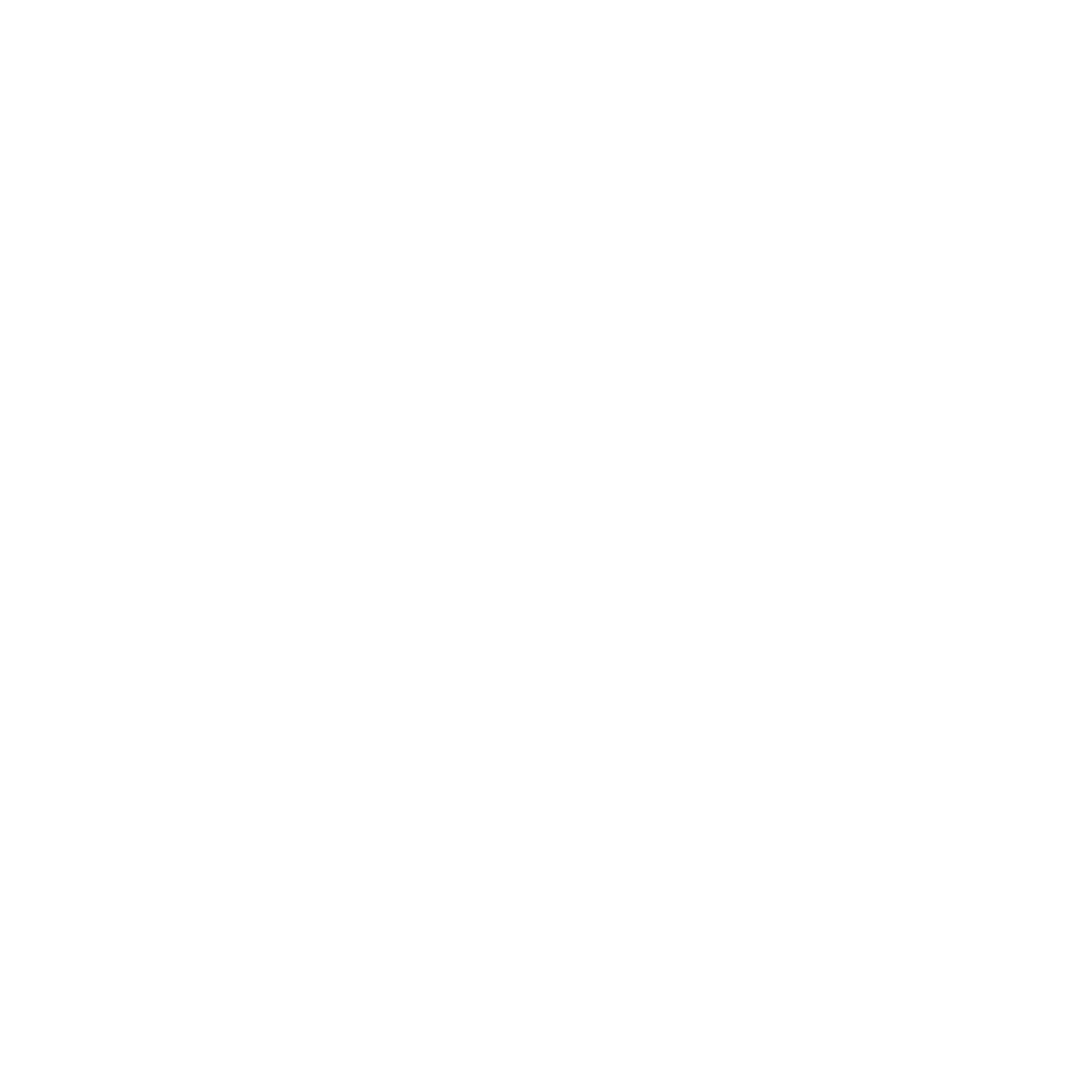

<IPython.core.display.Javascript object>


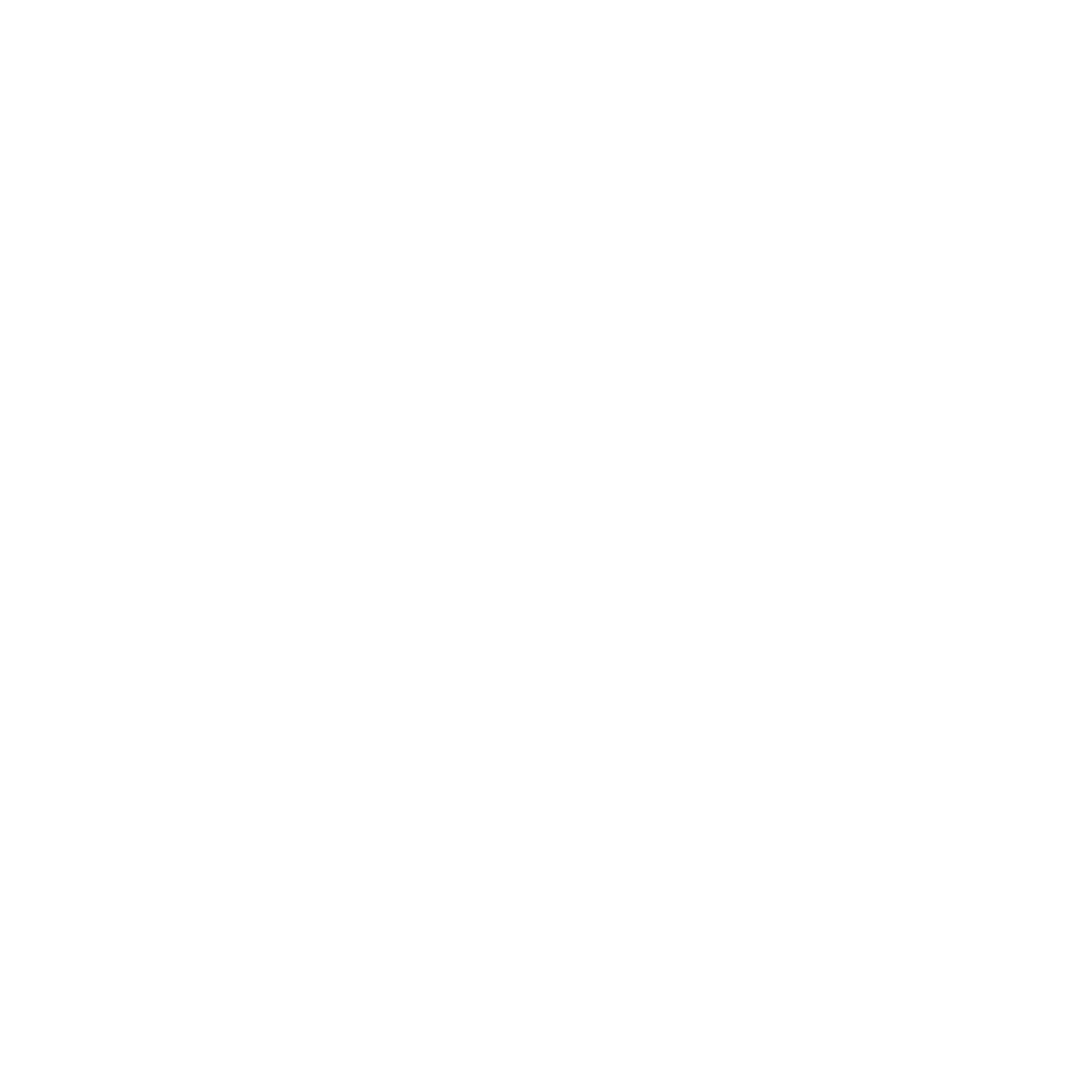

<IPython.core.display.Javascript object>


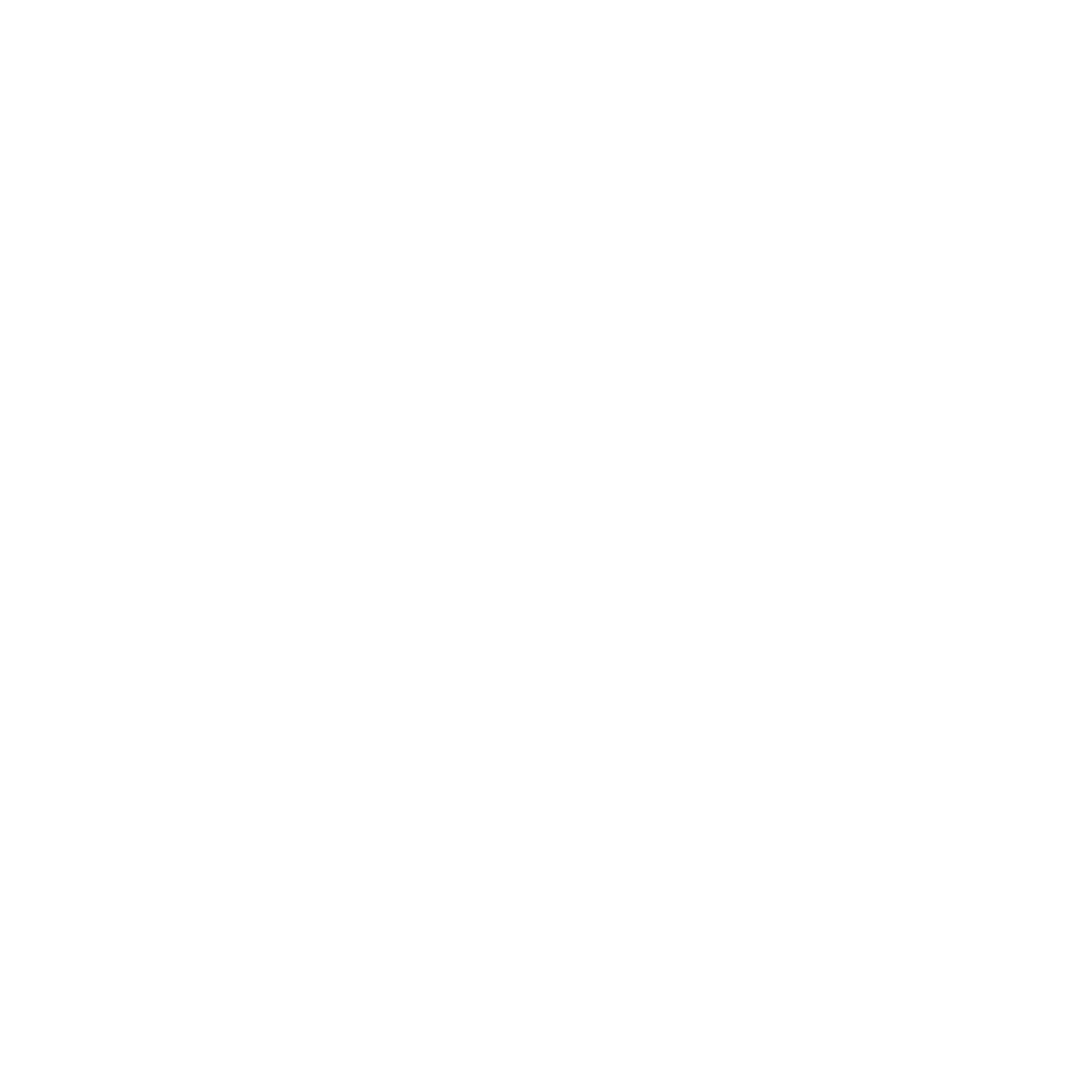

<IPython.core.display.Javascript object>


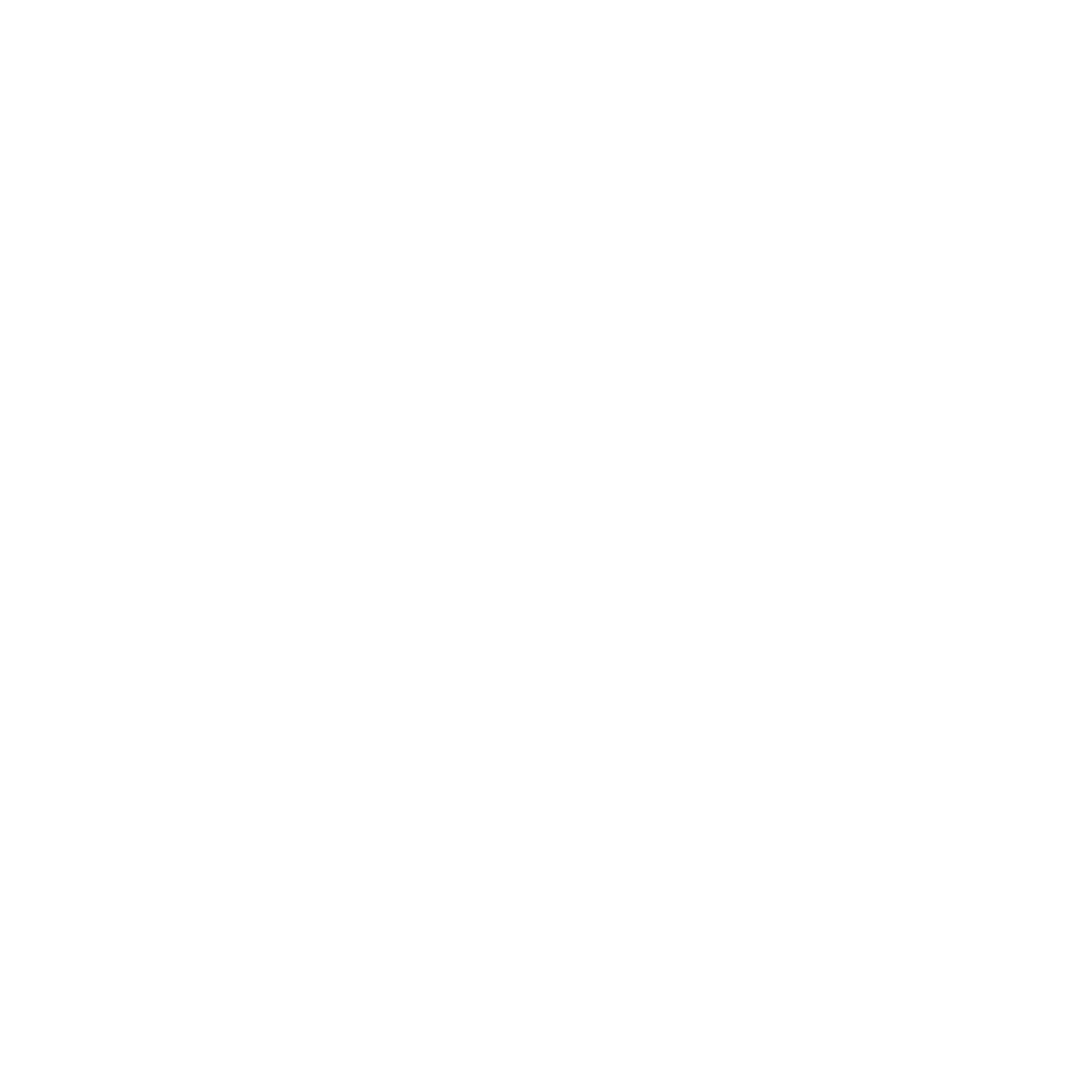

In [21]:

K = 4

kdt = KDTree(X, leaf_size=30, metric='euclidean')
idx = kdt.query(Y, k=K, return_distance=False)

K_ave = 30
kdt_Y = KDTree(Y, leaf_size=30, metric='euclidean')
idy = kdt_Y.query(Y, k=K_ave,return_distance=False)


x_id = X[idx]
x_idx = x_id[:,0,:]

print(x_id.shape)

# print(idy)
# use the closest points matching as initial guess
init_vy = x_idx[:, 1] - Y[:, 1]
init_vx = x_idx[:, 0] - Y[:, 0]

init_v = x_idx - Y

Y_stack_2nd = np.tile(Y.reshape(-1,1,2), (1,K,1)) # to be of shape N X K X 2


local_dis_v = x_id - Y_stack_2nd
local_disx = local_dis_v[:, :, 0]
local_disy = local_dis_v[:, :, 1]
print(local_dis_v.shape)

for i in range(len(init_vy)):
    local_ave_v = init_v[idy[i]].mean(axis=0)
#     print(local_dis_v[i,:].shape)
    
    angles = []
    vec_diff = []
    for j in range(len(local_dis_v[i,:])):
        angles.append(angle_between(local_ave_v, local_dis_v[i,j]))
        vec_diff.append(la.norm(local_ave_v - local_dis_v[i, j]))
    
    local_avex = init_vx[idy[i]].mean()
    local_avey = init_vy[idy[i]].mean()
    
    print(angles)
    print(vec_diff)
    closest_to_mean = np.argmin(vec_diff)
    
#     print(closest_to_mean)
    
    
    closest_to_mean_x = np.argmin(np.abs(local_avex - local_disx[i,:]))
    closest_to_mean_y = np.argmin(np.abs(local_avey - local_disy[i,:]))
#     print(closest_to_mean_x, closest_to_mean_y)
    
    
    if  closest_to_mean != 0:
        print('point {} associated to {}'.format(i, closest_to_mean))
        x_idx[i] = x_id[i, closest_to_mean, :]
    
    
#     print(local_ave)

from mpl_toolkits.mplot3d import Axes3D


%matplotlib notebook

fig = plt.figure(figsize=(12,12))
ax = Axes3D(fig)
ax.scatter3D(Y[:,0], Y[:, 1],  x_idx[:,0]-Y[:,0])

fig = plt.figure(figsize=(12,12))
ax = Axes3D(fig)
ax.scatter3D(Y[:,0], Y[:, 1],  x_idx[:,1]-Y[:,1])



size_grid = frames[0].shape
x_grid = np.linspace(0, size_grid[1], 50)
y_grid = np.linspace(0, size_grid[0], 50)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
Z = np.zeros((x_grid.size, y_grid.size))

## Smoothing using local weighted regression(lowess or loess)

(2, 2500)


<IPython.core.display.Javascript object>


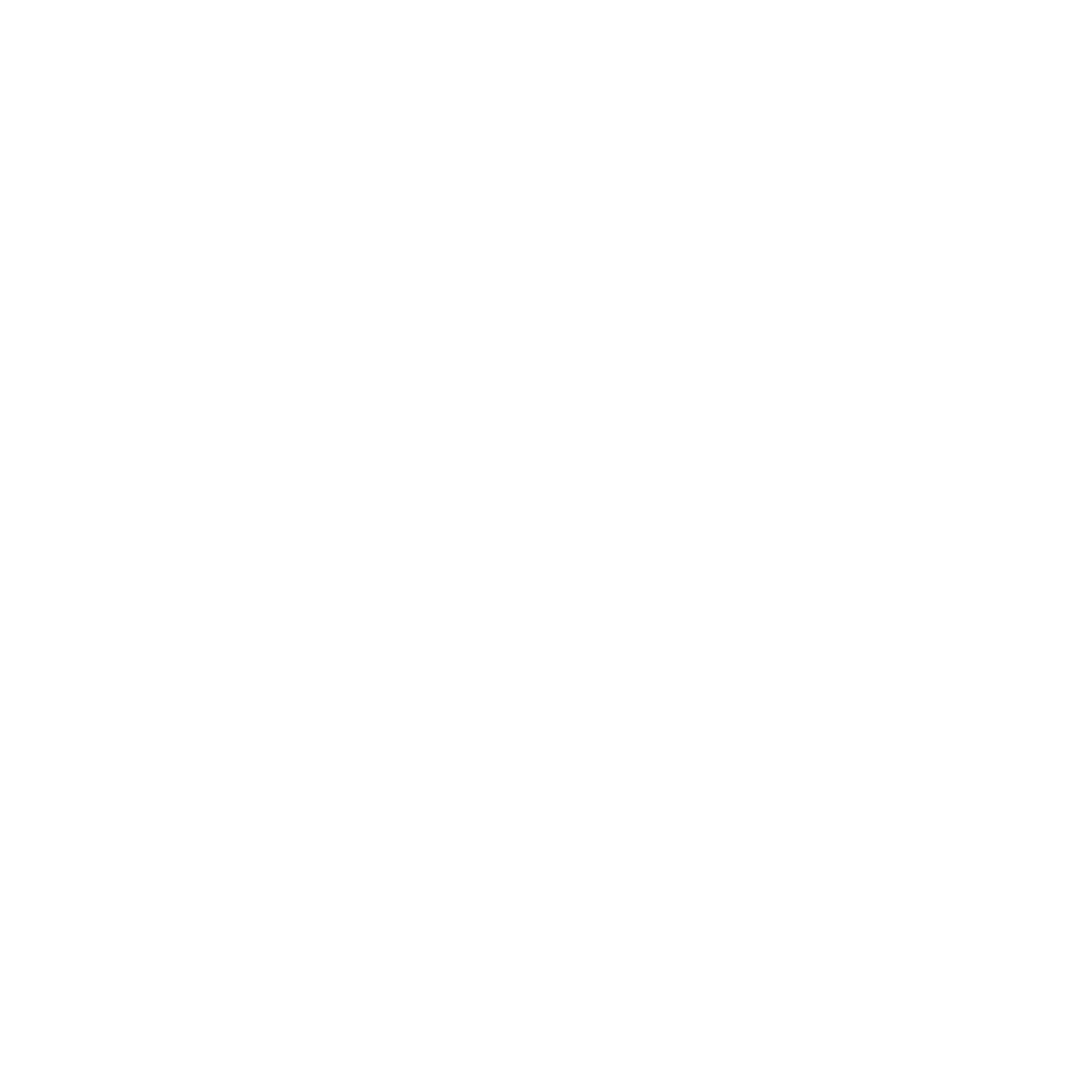

<IPython.core.display.Javascript object>


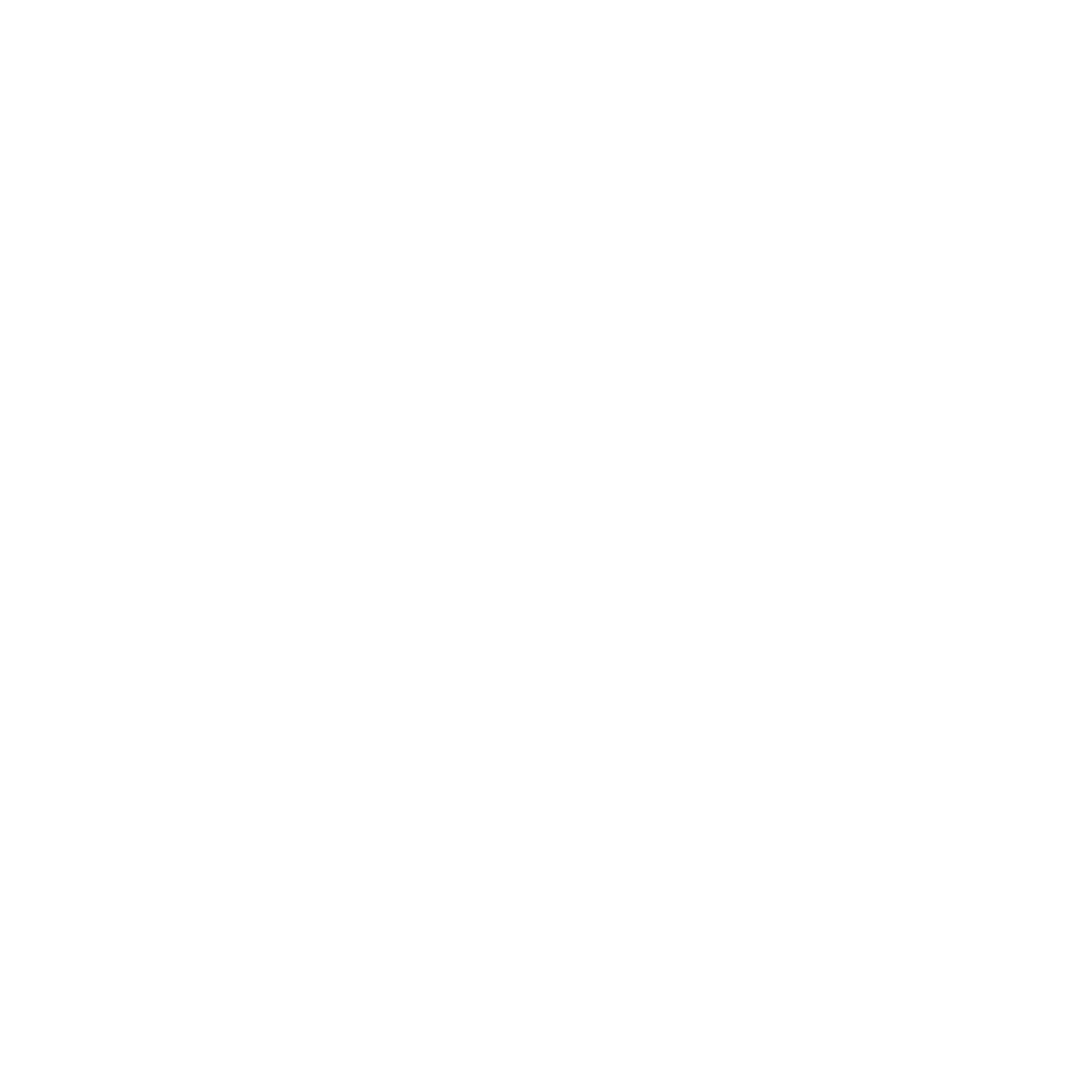

In [23]:
import lowess as lo

# 2D case (and more...)

f = x_idx[:, 0] - Y[:, 0]

x0 = np.vstack([B1.ravel(), B2.ravel()])

print(x0.shape)
f_hat = lo.lowess(Y.T, f.T, x0, kernel=lo.bi_square, deg=1, l = 50)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y[:,0], Y[:,1], f)
ax.scatter(x0[0], x0[1], f_hat, color='r')

## lowess example

<IPython.core.display.Javascript object>


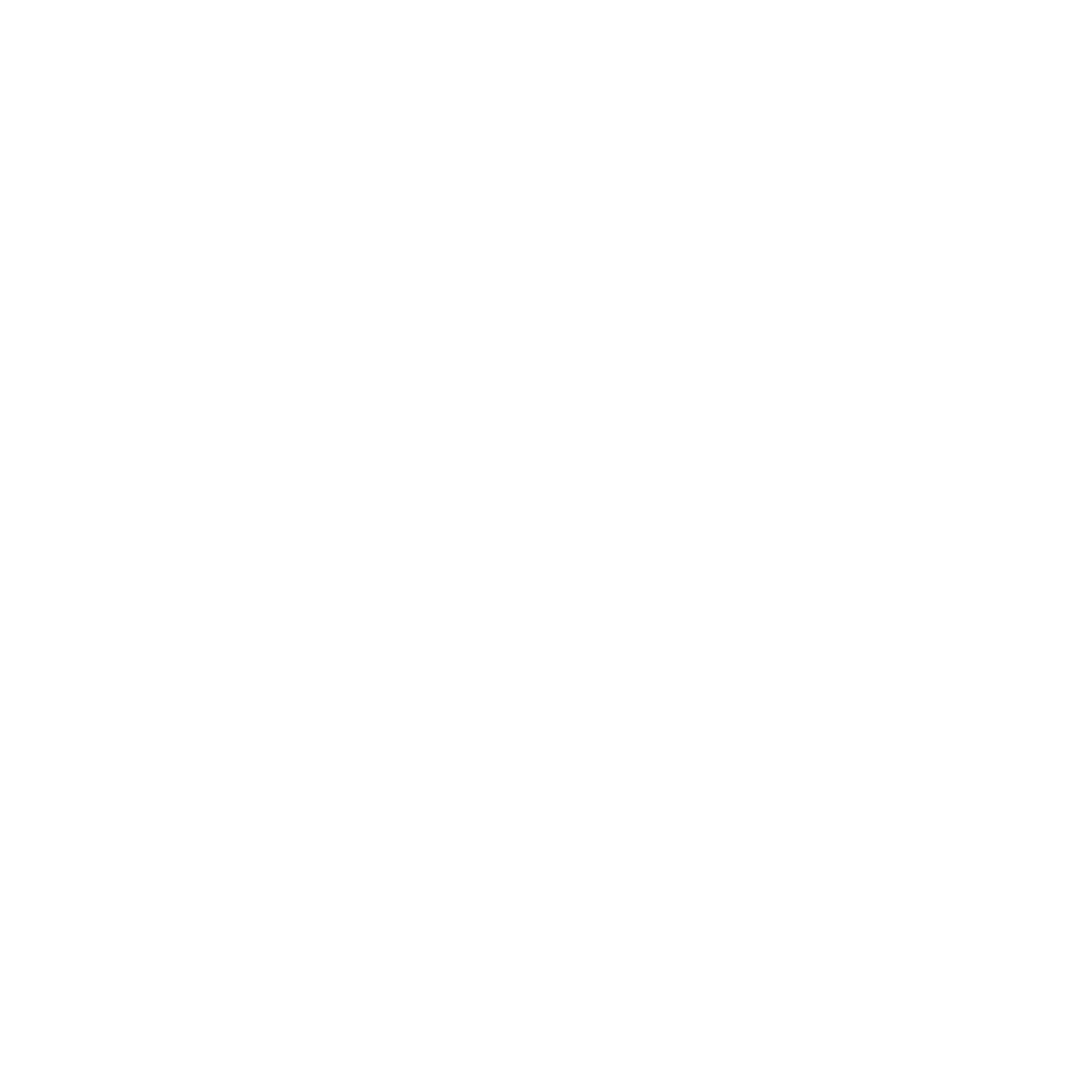

<IPython.core.display.Javascript object>


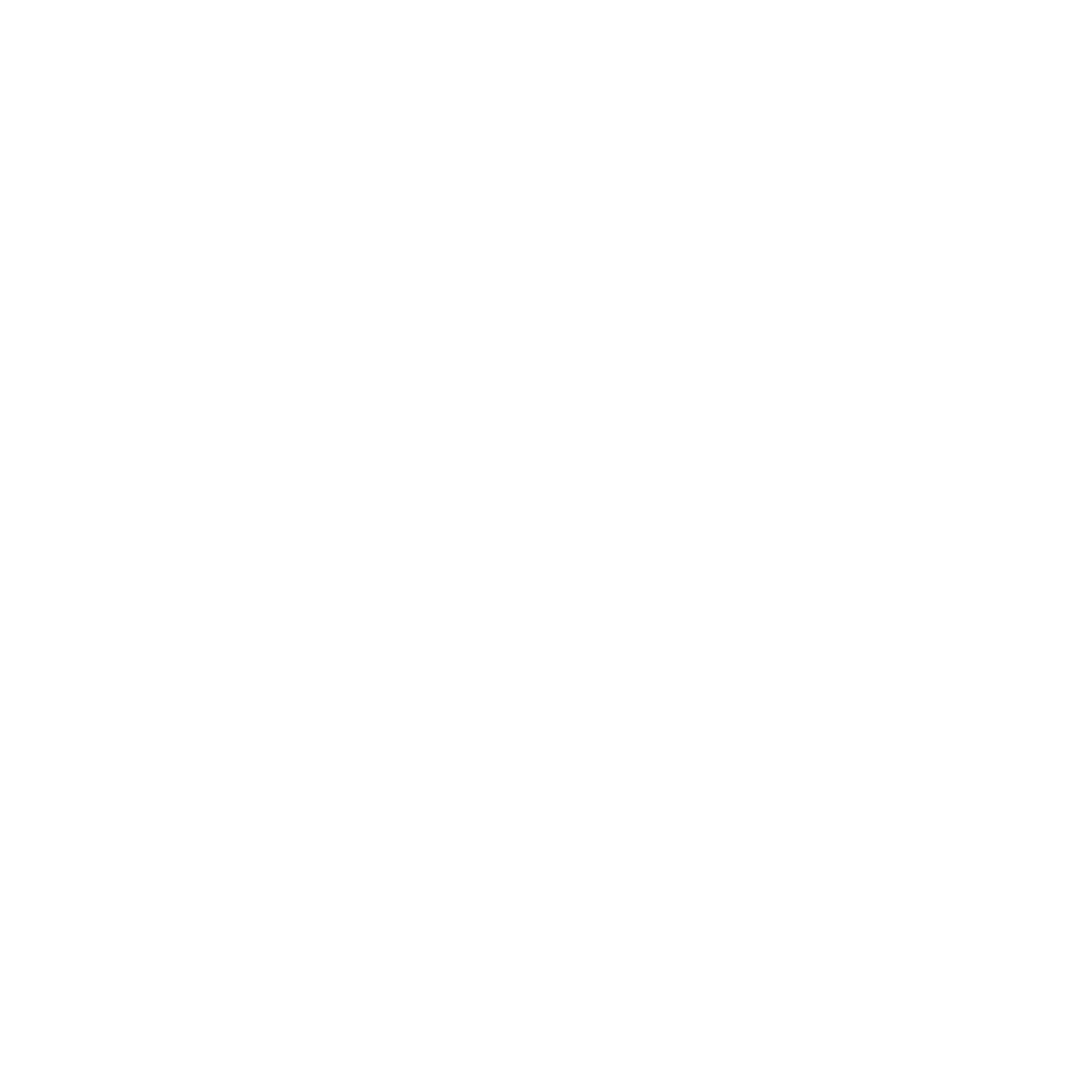

In [24]:
x = np.random.randn(2, 100)
f = -1 * np.sin(x[0]) + 0.5 * np.cos(x[1]) + 0.2*np.random.randn(100)
x0 = np.mgrid[-1:1:.1, -1:1:.1]
x0 = np.vstack([x0[0].ravel(), x0[1].ravel()])
f_hat = lo.lowess(x, f, x0, kernel=lo.bi_square, l=3, deg=2)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0], x[1], f)
ax.scatter(x0[0], x0[1], f_hat, color='r')
plt.show()

# smoothing surface using spline 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(210, 2)
(array([ 70,  74,  84,  86,  87,  88,  91,  95,  96,  97,  99, 102, 103,
       105, 110, 111, 114, 115, 116, 118, 119, 120, 123, 127, 130, 131,
       132, 133, 134, 135, 136, 137, 142, 150, 154, 158, 167, 174, 197]),)
(210, 2)
(array([ 63,  64,  79,  90,  95,  97,  98,  99, 104, 114, 115, 117, 120,
       121, 123, 124, 125, 128, 129, 130, 131, 13

/home/adam/.local/lib/python3.5/site-packages/scipy/interpolate/fitpack2.py:1051: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)


<IPython.core.display.Javascript object>


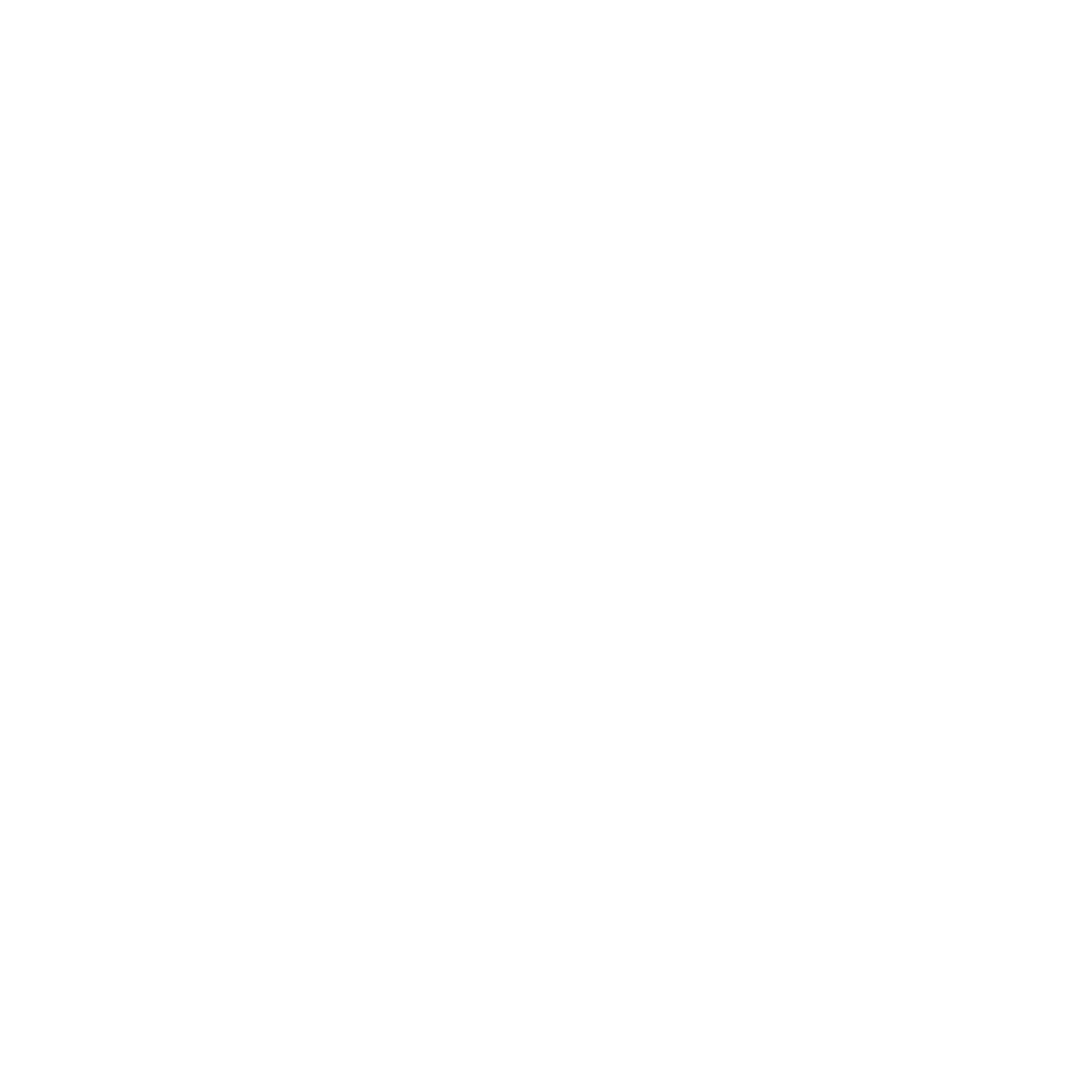

<IPython.core.display.Javascript object>


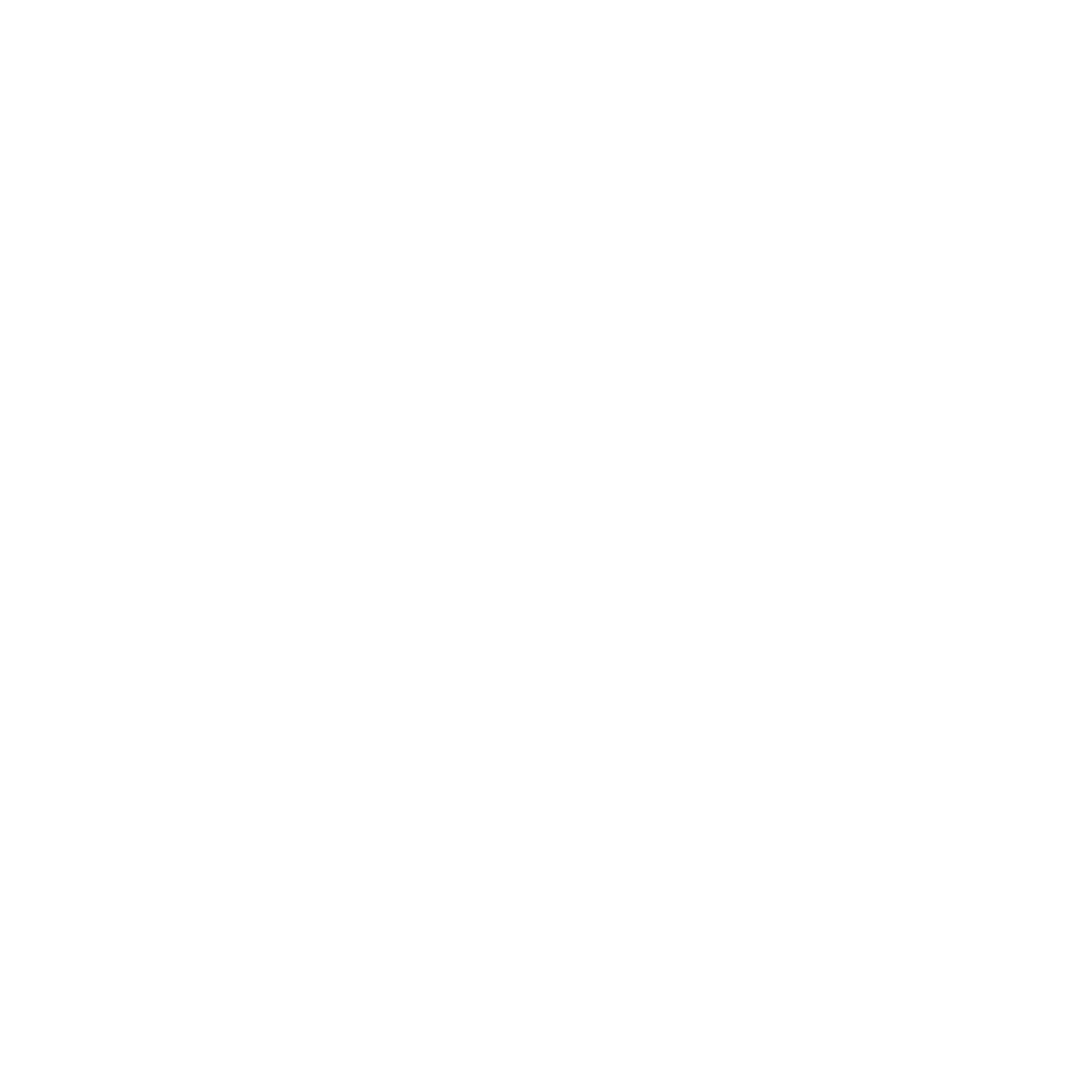

In [27]:
import scipy as sp
import scipy.interpolate


w = np.ones((len(Y)))
print(w)

for k in range(K):
    x_idx[w.nonzero()] = x_id[w.nonzero(), k, :]
    print(x_idx.shape)
    # ax.quiver(Y[:, 0], Y[:, 1], x_idx[:,0]-Y[:,0], x_idx[:,1]-Y[:,1], scale=250)

    bspl = sp.interpolate.SmoothBivariateSpline(
        Y[:, 0], Y[:, 1],  x_idx[:, 1]-Y[:, 1], s=900)
#     print(bspl)
    Z = bspl.ev(B1.flatten(), B2.flatten())
    Z = Z.reshape(50, 50)

#     fig = plt.figure(figsize=(12, 12))
#     ax = Axes3D(fig)
#     ax.plot_wireframe(B1, B2, Z)
#     ax.plot_surface(B1, B2, Z, alpha=0.2)
    # ax.scatter3D(Y[:,0], Y[:, 1],  x_idx[:,1]-Y[:,1], c='r')

    residuals = bspl.ev(Y[:, 0], Y[:, 1]) - (x_idx[:, 1]-Y[:, 1])

    # fig = plt.figure(figsize=(12,12))
    # plt.hist(residuals)

    w = (np.abs(residuals) > 2.5)*1
    print(w.nonzero())

    # fig = plt.figure(figsize=(12,12))
    # ax = Axes3D(fig)
#     ax.scatter3D(Y[w.nonzero(), 0], Y[w.nonzero(), 1],
#                  x_idx[w.nonzero(), 1]-Y[w.nonzero(), 1], c='b')

#     x_idx[w.nonzero()] = x_id[w.nonzero(), 1, :]
bspl = sp.interpolate.SmoothBivariateSpline(
    Y[:, 0], Y[:, 1],  x_idx[:, 1]-Y[:, 1], s=1900)
Z = bspl.ev(B1.flatten(), B2.flatten())
Z = Z.reshape(50, 50)

fig = plt.figure(figsize=(12, 12))
ax = Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z, alpha=0.2)
ax.scatter3D(Y[:, 0], Y[:, 1],  x_idx[:, 1]-Y[:, 1], c='r')

In [28]:
## polynomial fitting with minimize function from scipy.optimize

0.0
32055.374923527488
0.0
32055.374923527488
0.0
31566.33443335652
0.0
31664.62457816598
0.0
31566.33443335652
0.0
31474.09078882664
0.0
31497.29394099401
0.0
31473.639677219784
0.0
31473.697850744487
0.0
31473.697850744487
0.0
31473.639677219784
0.0
10385861.38920897
0.0
27275533.410938688
0.0
31473.639677219784
0.0
4018584.086156421
0.0
1534583.7836351162
0.0
31448.858902868767
0.0
31448.861380949405
0.0
31448.861380949405
0.0
31448.858902868767
5.574820355272423e-34
20641753.378414683
-9.037799506153e-34
54173222.18712711
0.0
31448.858902868767
-2.6788813103959475e-33
7947154.349946259
-3.2764674402776367e-32
3028236.9157599118
-7.313882834104739e-35
31426.19580110853
1.0669898874256423e-35
31426.198067423033
-4.4572370192779486e-35
31426.198067423033
-7.313882834104739e-35
31426.19580110853
-6.877781815167044e-22
945925806380.2853
7.464967699334311e-23
2476464205533.6523
-7.313882834104739e-35
31426.19580110853
-1.504645970154536e-20
361311111411.36
9.617547762328792e-21
138008828

-3.639937377873078e-05
30279.169036263407
-3.806985174849951e-05
30281.87526612131
-3.639937377873078e-05
30279.169036263407
-13059.39123353639
4.1641701025868025e+22
-34189.94594766559
1.0901939015215289e+23
-3.639937377873078e-05
30279.169036263407
-4988.246978467142
1.5905713727005878e+22
-1905.3385361280186
6.075441943751829e+21
-3.607975661728279e-05
30280.83830245906
-3.678781058683578e-05
30285.828110204166
-3.639937377873078e-05
30279.169036263407
-8.237800046448422e-05
30720.580557709458
-5.083322493088861e-07
31608.984405044255
-3.639937377873078e-05
30279.169036263407
-1.701654010973715e-05
30488.892722640714
-5.184651718709777e-05
30333.863109104634
-3.79918427553972e-05
30278.293023645252
-3.8007933570169904e-05
30278.293111246512
-3.797575522917591e-05
30278.293111246527
-8.891367713696672e-05
30803.703739162975
-3.79918427553972e-05
30278.293023645252
6.859369143100637e-13
1.8524318892107702e+23
-1.6191438003597694e-13
4.849729715261686e+23
-3.79918427553972e-05
30278.29

-2585.8271009014065
6.94872323214488e+21
-987.6963620283342
2.6541760595477576e+21
-4.107541550020032e-05
30269.756665169665
-4.284612588089337e-05
30272.13101543896
-4.107541550020032e-05
30269.756665169665
-13058.983710313509
4.1641701025948245e+22
-34188.87976163938
1.0901939015202309e+23
-4.107541550020032e-05
30269.756665169665
-4988.091489281794
1.5905713726956304e+22
-1905.2790389676527
6.075441943782467e+21
-4.0690857404659626e-05
30272.228042515486
-4.15287223654475e-05
30275.613627960323
-4.107541550020032e-05
30269.756665169665
-8.954220382241473e-05
30735.884110719788
-1.096057480237914e-06
31559.5808284711
-4.107541550020032e-05
30269.756665169665
-2.013714667169121e-05
30464.205070748656
-5.747779924068836e-05
30333.891380672376
-4.1749363705558193e-05
30269.61725588923
-4.1756129586702654e-05
30269.617269830156
-4.174259834709163e-05
30269.617269830156
[-2.28922481e+00  1.21821173e-02 -1.70736045e-03  2.65077226e-05
 -1.79594140e-05  1.24506625e-05  2.57820231e-08 -7.942

<IPython.core.display.Javascript object>


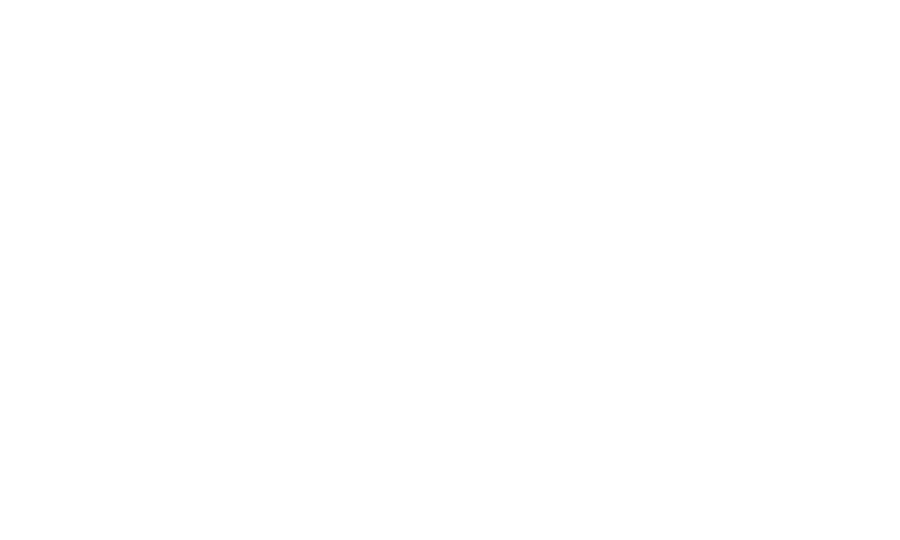

<IPython.core.display.Javascript object>


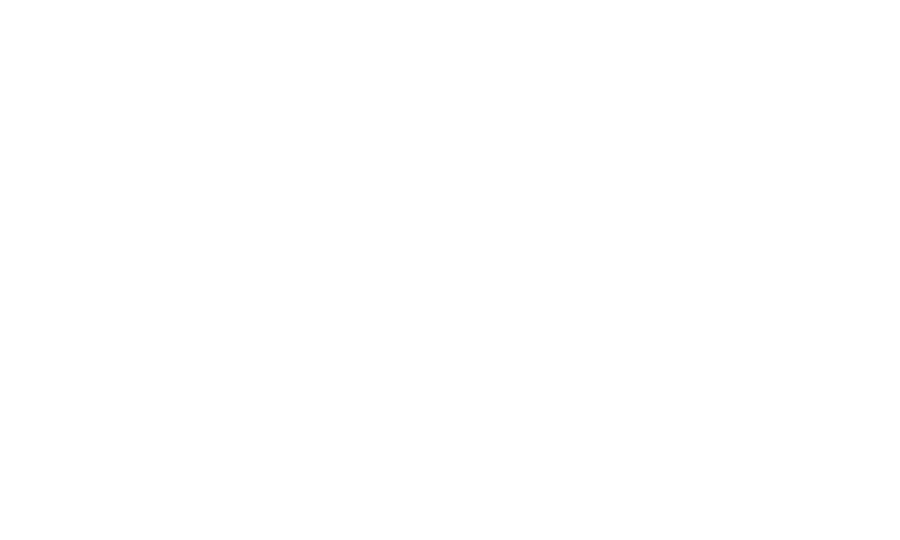

In [29]:
def polymodel(coeff, data):
    # here we simply use a 4th order polynomial to fit the data
    out = np.matmul(coeff, data)
#     print(out.shape)
    return out

def gaussian_curvature(Z, spacing):
    # https://stackoverflow.com/questions/11317579/surface-curvature-matlab-equivalent-in-python
    # np.gradient(Z, grid_spacing) return matrix by axis here x and y
    Zy, Zx  = np.gradient(Z, spacing)
    Zxy, Zxx = np.gradient(Zx, spacing)
    Zyy, _ = np.gradient(Zy, spacing)

    K = (Zxx * Zyy - (Zxy ** 2)) /  (1 + (Zx ** 2) + (Zy **2)) ** 2             
    return K



def objective(coeff, data, target, grid_xy):
    
    # trade-off const
    lam = 1
    # The function we care about
    prediction = polymodel(coeff, data)
    # (optional) L2 regularization to keep coeff small
    # (optional) reg_amount = 0.0
    # (optional) reg = reg_amount * np.sqrt((coeff ** 2).sum())
    pred_fit = polymodel(coeff, grid_xy)
    prediction_2d = pred_fit.reshape(50, 50)
    g_curvature = gaussian_curvature(prediction_2d, 10)
    g_c_sum = g_curvature.sum()
    
    print(g_c_sum)
    
    losses = (prediction - target) ** 2 
    # (optional) losses += reg
    # Return the average squared error
    loss = losses.sum() + lam*g_c_sum
    
    #
    print(loss)
    return loss


    


# polynomial order 4
O = 4
data = []
x, y = Y[:,0], Y[:,1]

grid_data = []
x_g = B1.flatten()
y_g = B2.flatten()

for i in range(0,5):
    for j in range(0, i+1):
#         print(i, j)
        data.append(x**j*y**(i-j))
        grid_data.append(x_g**j*y_g**(i-j))

data = np.array(data)
grid_data = np.array(grid_data)

# coeffs = 0.001*np.ones((1, 15))
coeffs = np.zeros((1,15))





# print(polymodel(coeffs, data))
# print(objective(coeffs, data,  grid_data))


general_result = sp.optimize.minimize(objective, coeffs,
                                         method='Powell',
                                         args=(data, x_idx[:,1]-Y[:,1], grid_data))


# Test what the squared error of the returned result is
coeff = general_result.x
out = polymodel(coeff, grid_data)
# print('====================')
# print('general_result =\n%s' % (general_result,))
# print('---------------------')
# print('general_output = %r' % (general_output,))
# print('====================')

out = out.reshape(50,50)
print(coeff)

fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)
ax.plot_wireframe(B1, B2, out)
ax.plot_surface(B1, B2, out,alpha=0.2)
ax.scatter3D(Y[:,0], Y[:, 1],  x_idx[:,1]-Y[:,1], c='r')

# using gaussian 2d fitting

In [30]:
def gaussian_2d(coeff, data):
    
    x = data[:, 0]
    y = data[:, 1]
    
    amplitude, xo, yo, sigma_x, sigma_y, theta, offset = np.split(coeff, 7)
    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    
#     print(a, b, c, z_offset, Amp, xo, yo)
    
    
    out = offset + amplitude*np.exp(-( a*(x - xo)**2 + 2*b*(x - xo)*(y - y0) + c*(y - yo)**2 ))
#     print(out)
    
    return out



def objective(coeff, data, target):
    
    
    # The function we care about
    prediction = gaussian_2d(coeff, data)
    
    losses = (prediction - target) ** 2
    print(losses.shape)
    # (optional) losses += reg
    # Return the average squared error
    loss = losses.sum()
    print(loss)
    
    return loss


    


data = Y

import scipy.io as sio
# print(data.shape)

# scipy.io.savemat('./datapoints.mat', mdict={'xy': data, 'z': x_idx[:,1]-Y[:,1]})

x_g = B1.flatten()
y_g = B2.flatten()

xy_g = np.array([x_g, y_g]).T


# print(xy_g)


coeffs = np.array([10, 250, 200, 20, 20, 0, 0.1])
print(coeffs)




# general_result = sp.optimize.minimize(objective, coeffs,
#                                          method='Nelder-Mead',
#                                          args=(data, x_idx[:,1]-Y[:,1]))


# # Test what the squared error of the returned result is
# coeff = general_result.x

# print(coeff)
out = gaussian_2d(coeffs, xy_g)
# print('====================')
# print('general_result =\n%s' % (general_result,))
# print('---------------------')
# print('general_output = %r' % (general_output,))
# print('====================')

out = out.reshape(50,50)
print(coeff)

fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)
ax.plot_wireframe(B1, B2, out)
ax.plot_surface(B1, B2, out,alpha=0.2)

ax.scatter3D(Y[:,0], Y[:, 1],  x_idx[:,1]-Y[:,1], c='r')

[1.0e+01 2.5e+02 2.0e+02 2.0e+01 2.0e+01 0.0e+00 1.0e-01]


NameError: name 'y0' is not defined

All is well.
